In [358]:
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\mabock\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'f', 'clf', 'rec']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Part 1 - Exploratory data analysis
##### customer requests us to open the json logins file which contains timestamps of user logins from some geo location.  Specific request to aggregate the counts in 15-min time intervals which is to be used to visualize and describe the underlying patterns of demand.  Note any data quality issues.

In [359]:
# load json as pandas df
logins_json_df = pd.read_json('../ultimate_challenge/logins.json')
logins_json_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [360]:
logins_json_df.info()
#the data is roughly 93k+ entries of datetime with random login times and there are no Null values seen

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [361]:
#first let's aggegrate the counts into 15min intervals as requested
#we will need a counts column and index the df by login_time stamps.


logins_json_df.set_index('login_time', inplace = True)
logins_json_df['login_counts'] = 1
logins_json_df.info()
logins_json_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 1 columns):
login_counts    93142 non-null int64
dtypes: int64(1)
memory usage: 1.4 MB


,login_counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [362]:
#then we do a resample every 15min and get the sum of login_counts for each block

converted_df = logins_json_df.resample('15T').sum() 
converted_df.head()

,login_counts
login_time,
1970-01-01 20:00:00,2.0
1970-01-01 20:15:00,6.0
1970-01-01 20:30:00,9.0
1970-01-01 20:45:00,7.0
1970-01-01 21:00:00,1.0


In [363]:
#basic stats of the login counts every 15min block
converted_df.describe()

,login_counts
count,9381.000000
mean,9.928792
std,8.263146
min,1.000000
25%,4.000000
50%,8.000000
75%,14.000000
max,73.000000


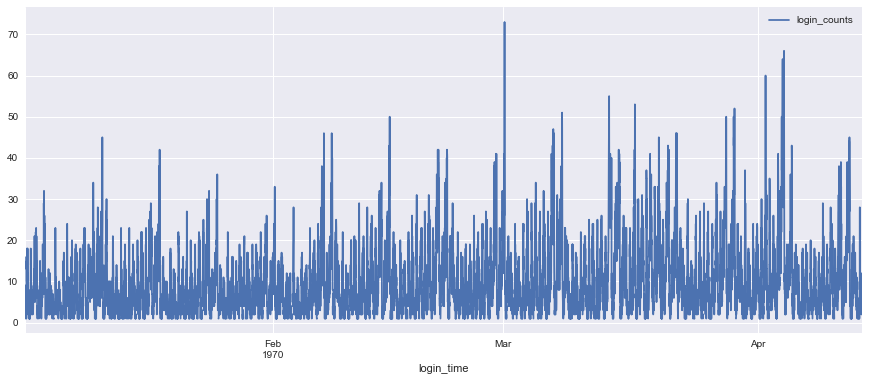

In [364]:
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (15, 6)
converted_df.plot()

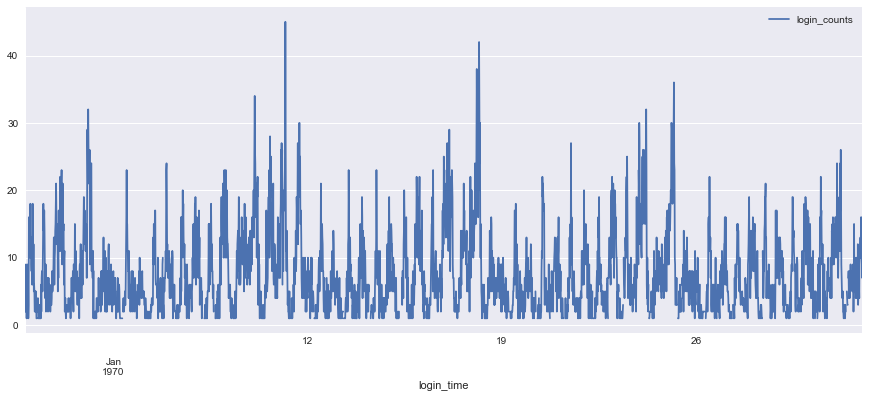

In [365]:
converted_df['1970-01-01': '1970-01-31'].plot()

### this is somewhat difficult to read but we can see some waveform to the data which is indicative of a pattern in logins.  Perhaps login times may be better visualized by looking at month, business days, or during business hours.

In [366]:
#reread data in
logins_df = pd.read_json('logins.json')
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [367]:
#create weekday counts
weekday_df = logins_df.copy()
#weekday_df['week_day_counts'] = logins_df['login_time'].map(lambda day: day.weekday())
weekday_df['day-of-week'] = logins_df['login_time'].dt.weekday_name
weekday_df.set_index('login_time', inplace = True)
weekday_df_counts = weekday_df.resample('D').count()
weekday_df_counts.head()

,day-of-week
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [368]:
#we can quickly check that our weekday counter adds up to the total number of logins and it does.
weekday_df_counts.sum()

day-of-week    93142
dtype: int64

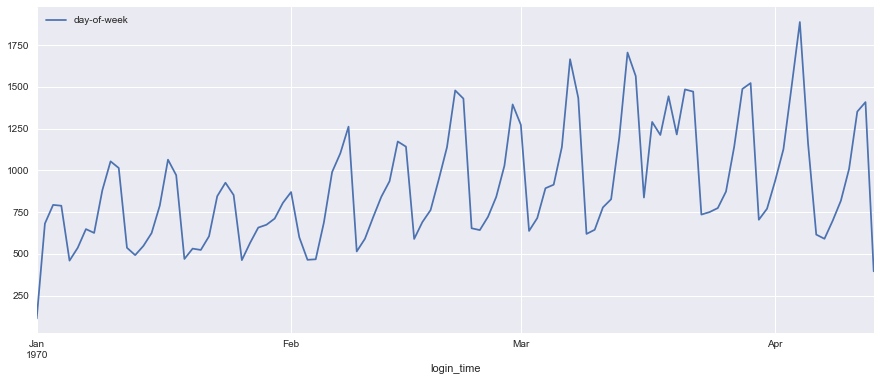

In [369]:
weekday_df_counts.plot()

### We can see a strong trend in the data looking by day of the week counts.  

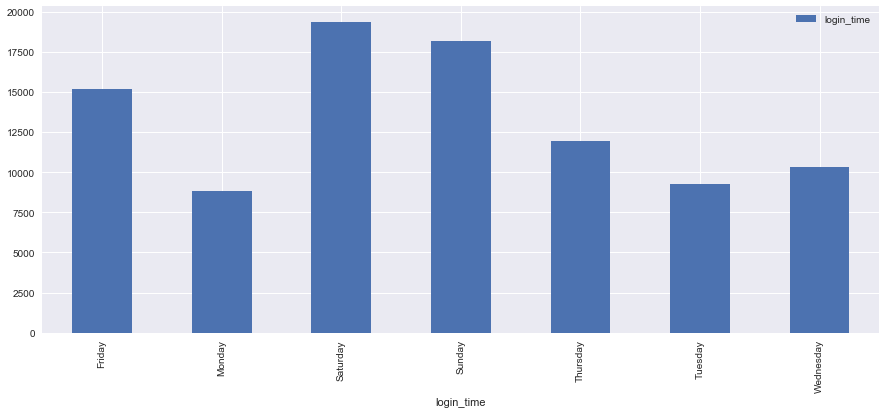

In [370]:
weekday_df = logins_df.copy()
#weekday_df['day-of-week'] = logins_df['login_time'].dt.weekday_name
logins_df.groupby(logins_df['login_time'].dt.weekday_name).count().plot(kind='bar')

### Histogram of day occurences shows us that the weekends are driving higher login counts in the weekly cycle.

# Part 2 ‑ Experiment and metrics design


The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.


### 1 metrics:
To measure success of the experiment where drivers are encouraged to serve both cities, I would focus on a metric that captures active work in each city per worker.  Options could be the amount(%) of time each driver spends working in each of the cities or perhaps number of jobs per city per driver or % of fairs in dollars collected per city.  Without data on hand, I would choose the simplest and look at % of time per city per driver.  

Currently the drivers are assumed to spend near 100% of their time in their respective cities based on the information provided.  The ideal outcome appears to be drivers spending their time near 50%-50% between the two.  A more realistic expectation would be that driver location trends move in the direction of a better split but probably not the ideal 50-50.  To improve driver availability across cities, there must be an incentive to change the current habits.  By providing reimbursment of tolls, the city managers are at least removing some of the penalty that would be incurred by travelling across the tolls.  The eventual outcome may also need to address monetary incentives for driving in one city vs the other due to increased fairs.  

### 2 experimental design:
Desired outcome is to see a stastical improvement in % of time drivers spend in each city.  Because there could be some lag in the driving trends reacting to implementing the toll reimbursement change, we need to ensure a long enough test time such that we capture the real effect and have a large sample size.   I would therefore select a minimum of 60days for the testing period.  

Because we assumed the ratio of time spent in non-native city ~0, the ideal ratio is 1 (50-50).  This is one directional and allows us to use a one-tailed z-testing metric.  We would like reject a null hypothesis in our test statistic using a 95% confidence interval.  Based on the outcome we will be able to determince with high confidence if the ratio of time spent in each city has changed as intended.  Recommendations could be influenced by the cost of the program vs actual gain.  If total fairs collected do not improve, then the toll reimbursement may be too costly to implement.  We must be careful when analyzing total fairs collected as they may be influenced by seasonality trends that must be taken into account.  An example of this might be our 2mo experimental period is at peak tourism time so total fairs might need to be compared to previous peak tourism years.

# Part 3: Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

### Data description
● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [371]:
#open the joson file and load is the pd dataframe
data = open('../ultimate_challenge/ultimate_data_challenge.json')
data_df = pd.DataFrame(json.load(data))
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [372]:
#first we want to check the formats and values of each column in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


We can see from the table above that our date columns are not formatted into datetime so we will need to take care of that.  We can also see that we have some missing data values in a few of the columns that will need to be addressed:

      avg_rating_by_driver      
      avg_rating_of_driver  
      phone     

In [373]:
#date columns that are currently string objects must be converted to data-time formats.
data_df['last_trip_date'] = pd.to_datetime(data_df['last_trip_date'])
data_df['signup_date'] = pd.to_datetime(data_df['signup_date'])

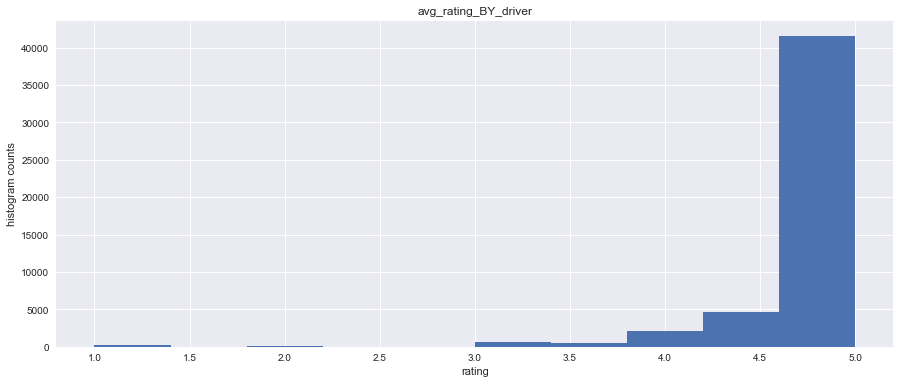

In [374]:
#now lets look closer at the columns which are missing data
plt.hist(data_df['avg_rating_by_driver'].dropna())
plt.title('avg_rating_BY_driver')
plt.xlabel('rating')
plt.ylabel('histogram counts')

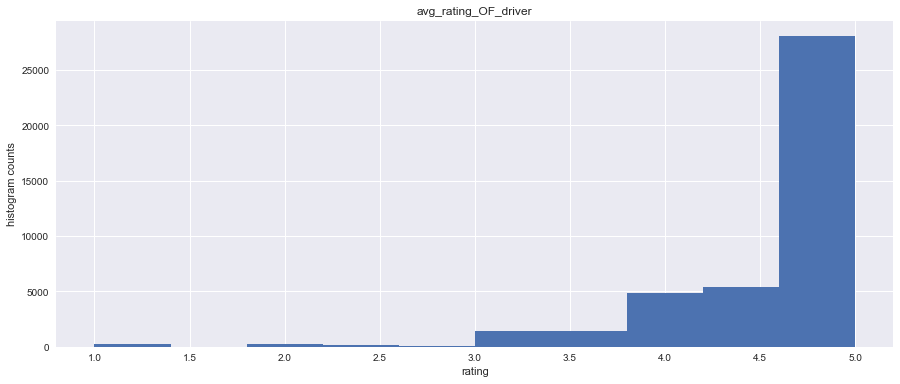

In [375]:
plt.hist(data_df['avg_rating_of_driver'].dropna())
plt.title('avg_rating_OF_driver')
plt.xlabel('rating')
plt.ylabel('histogram counts')

In [376]:
len(data_df)

50000

iPhone     34582
Android    15022
Name: phone, dtype: int64
Ratio iPhone:Android  2.30209026761


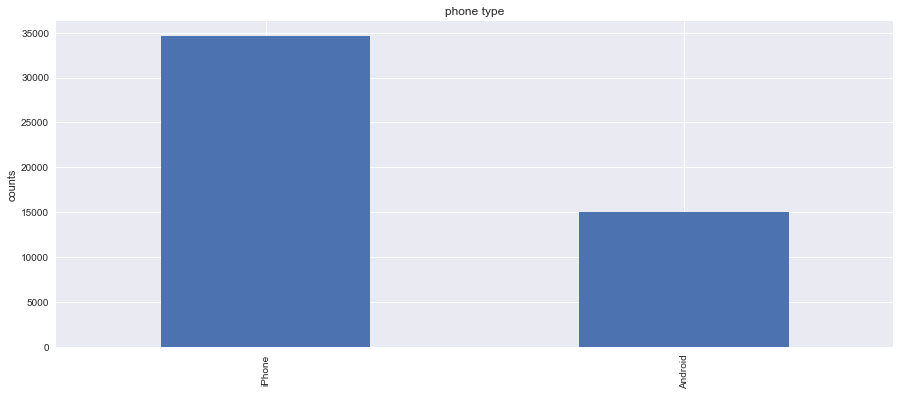

In [377]:
x = data_df['phone'].value_counts()
print (x)
print ('Ratio iPhone:Android ', x['iPhone']/x['Android'])

x.plot.bar()
plt.title('phone type')
plt.ylabel('counts')

Because the histogram for avg ratings per driver is very skewed we will replace missing value with the mean of all data.
For the phone type we will replace missing values in a ratio that maintains the known ratio of 2.3 iPhones for every Android.

In [378]:
data_df['avg_rating_by_driver'].fillna(data_df['avg_rating_by_driver'].mean(), inplace=True)
data_df['avg_rating_of_driver'].fillna(data_df['avg_rating_of_driver'].mean(), inplace=True)
data_df ['phone'] = data_df['phone'].fillna((pd.Series(np.random.choice(['iPhone', 'Android'], \
                    p=[0.70, 0.30], size=len(data_df)))))
new_x = data_df['phone'].value_counts()
print (new_x)
print ('Ratio iPhone:Android ', new_x['iPhone']/new_x['Android'])


iPhone     34847
Android    15153
Name: phone, dtype: int64
Ratio iPhone:Android  2.29967663169


We can see our random fillna for phone type retained the original ratio of phone types well.  Now let's check our dataframe again to make sure we have all values filled in and also check the column stats.

In [379]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [380]:
data_df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


Now let's check for typo's or string differences in the categorical data.  If any then we can convert typos to a unified match.

In [381]:
#create list of feature types
num_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge','surge_pct',
               'trips_in_first_30_days','weekday_pct']
cat_features = ['city','phone','ultimate_black_user']

In [382]:
for f in cat_features:
    print (data_df[f].unique())

["King's Landing" 'Astapor' 'Winterfell']
['iPhone' 'Android']
[True False]


Luckily there appears to be no typo's in the data so we need do nothing further.

In [383]:
#Final data cleaning excercise will remove 3s data outliers from numerical data

for n in num_features:
    #keep only the ones that are within +3 to -3 standard deviations in the numerical column.
    data_df =  data_df[np.abs(data_df[n]-data_df[n].mean())<=(3*data_df[n].std())] 
data_df.reset_index(drop=True, inplace = True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 12 columns):
avg_dist                  44666 non-null float64
avg_rating_by_driver      44666 non-null float64
avg_rating_of_driver      44666 non-null float64
avg_surge                 44666 non-null float64
city                      44666 non-null object
last_trip_date            44666 non-null datetime64[ns]
phone                     44666 non-null object
signup_date               44666 non-null datetime64[ns]
surge_pct                 44666 non-null float64
trips_in_first_30_days    44666 non-null int64
ultimate_black_user       44666 non-null bool
weekday_pct               44666 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


Now let's compute and plot a correlation matrix and visualize the skewness of each feature

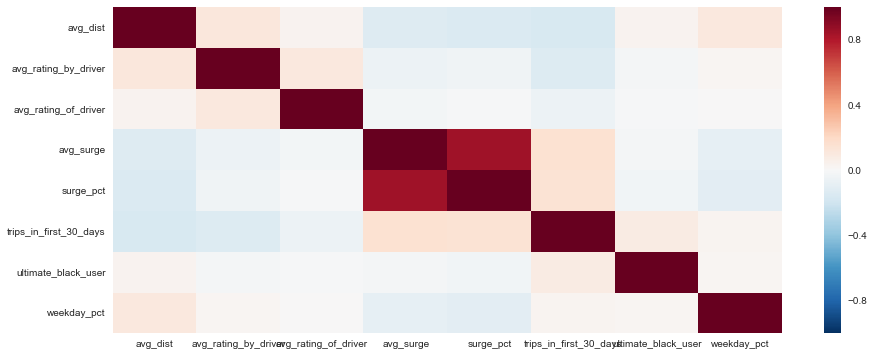

In [384]:
import seaborn as sns

corr = data_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

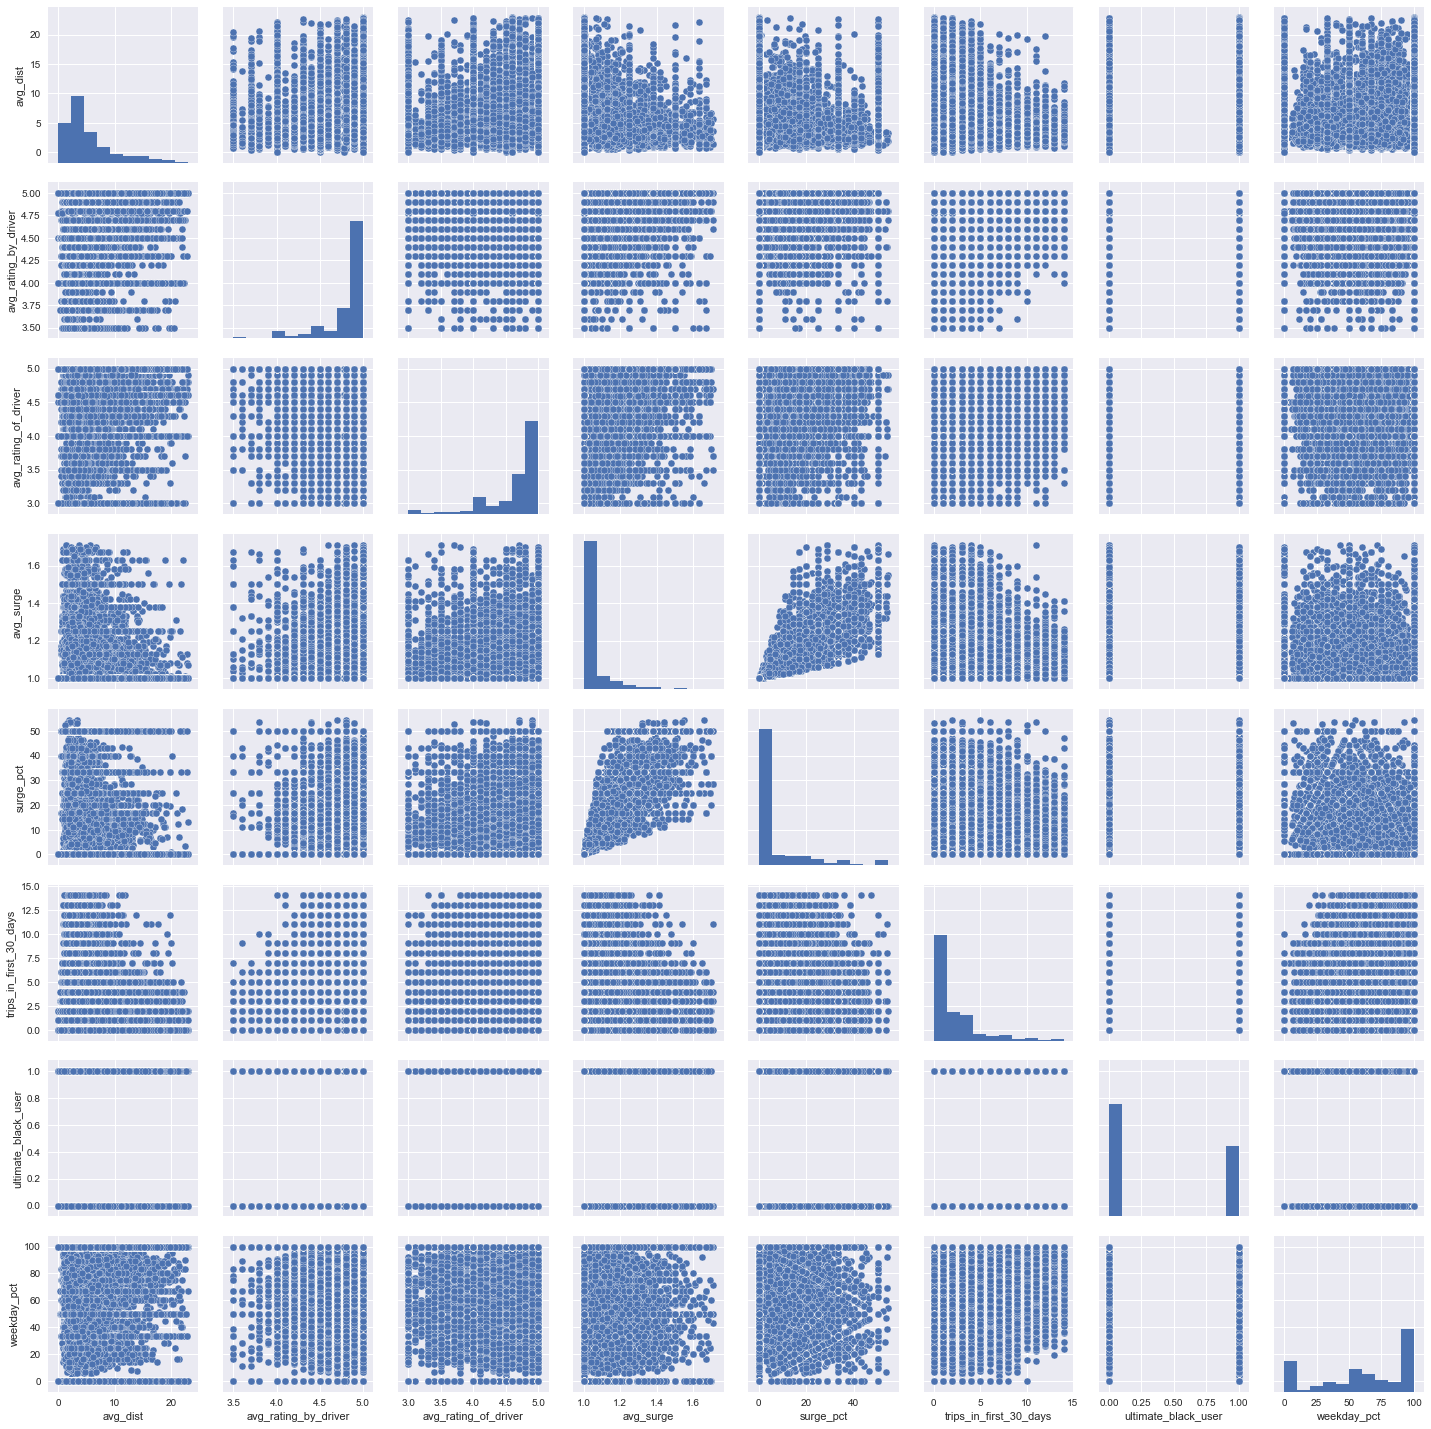

In [385]:
sns.pairplot(data_df)

We can see a high degree of correlation in the pairplot and heatmap for surge_pct and avg_surge

### What fraction of observed users were retained?
we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.  To answer this question we will look at the last date available in the dataset and then calculate users -30days as a % of the original total in the dataset.

In [386]:
retained_count = len(data_df[data_df['last_trip_date'] >= sorted(data_df['last_trip_date'].unique())[-30]])
print ('The percent of retained users taking a trip in the last 30 days is:', retained_count/len(data_df)*100)

The percent of retained users taking a trip in the last 30 days is: 37.574441409573275


### Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model?  Include any key indicators of model performance

In [387]:
#Modeling retention will require us to create a retention column that is calculated as active in last 30 days
data_df['retained'] = np.nan
data_df.loc[data_df['last_trip_date'] >= sorted(data_df['last_trip_date'].unique())[-30], 'retained'] = 1
data_df['retained'].fillna(0, inplace = True)
data_df.drop('last_trip_date', axis=1, inplace = True)  #key to drop this otherwise we will overfit as this represents retained
data_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,Android,2014-01-27,11.8,14,False,82.4,0.0


Ensuring we drop the 'last_trip_date' is key because it represents the retained label we just created.  If left in we will grossly overfit.  We will now check several models in cross_val train_test_split.  We will need to label
encode categorical data and drop all the datetime features to utlize in sklearn.

In [388]:
#this will label encode every categorical column 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_df = data_df.apply(le.fit_transform)
encoded_df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,358,16,18,10,1,1,24,144,4,1,176,1
1,817,16,21,0,0,0,28,0,0,0,203,0
2,68,16,13,0,0,1,5,0,3,0,630,0
3,227,15,16,14,1,1,9,185,9,1,464,1
4,304,15,14,19,2,0,26,112,14,0,485,0


In [389]:
#split into X data and y labels
X = encoded_df.drop('retained',axis=1)
y = encoded_df['retained']

Our data is best represented by the following attributes:
1. Predicting a category
2. Data is labeled
3. Less than 100k samples
4. No text data

We will therefore check several classical algorithmns for this type of data:
Linear SVC, KNeighbors, Decision Tree

In [390]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.linear_model import SGDClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

#create instances
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('TREE', DecisionTreeClassifier(max_depth=4)))
models.append(('SVM', LinearSVC(C = .001)))
print (models)

[('KNN', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')), ('TREE', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')), ('SVM', LinearSVC(C=0.001, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]


In [391]:
results = []
precision = []
recall = []
names = []
scoring = 'accuracy'


#loop through models and let cross_val_score perform train/test splits for us.

for name,model in models:
    skf = StratifiedKFold(n_splits=10, random_state=42)  #we will use stratifiedKfold
    cv_results = model_selection.cross_val_score(model, X, y, cv = skf, scoring = scoring)
    prec = model_selection.cross_val_score(model, X, y, cv = skf, scoring='precision')
    rec = model_selection.cross_val_score(model, X, y, cv = skf, scoring='recall')
    
    results.append(cv_results)
    precision.append(prec)
    recall.append(rec)
    names.append(name)
    
    print ('Accuracy  Results {:8}:    mean {:.2f},   std{:.2f},    '.format(name, cv_results.mean(), cv_results.std()))
    print ('Precision Results {:8}:    mean {:.2f},   std{:.2f},    '.format(name, prec.mean(), prec.std()))
    print ('Recall    Results {:8}:    mean {:.2f},   std{:.2f},    '.format(name, rec.mean(), rec.std()))
    print ('\n')

Accuracy  Results KNN     :    mean 0.70,   std0.00,    
Precision Results KNN     :    mean 0.62,   std0.01,    
Recall    Results KNN     :    mean 0.51,   std0.01,    


Accuracy  Results TREE    :    mean 0.74,   std0.01,    
Precision Results TREE    :    mean 0.66,   std0.01,    
Recall    Results TREE    :    mean 0.61,   std0.02,    


Accuracy  Results SVM     :    mean 0.67,   std0.04,    
Precision Results SVM     :    mean 0.63,   std0.07,    
Recall    Results SVM     :    mean 0.44,   std0.22,    




In [393]:
print (models[1])

('TREE', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))


Out of the box decision tree appears to give us the best fit to our data from the models.  Let's check if doing gridsearch of parameters on decision tree can improve results.

In [423]:
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier()
# set of parameters to test
param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20],
              "max_depth": [None, 2, 5, 10],
              "min_samples_leaf": [1, 5, 10],
              "max_leaf_nodes": [None, 5, 10, 20],
              }

skf = StratifiedKFold(n_splits=10, random_state=42)  #we will use stratifiedKfold
opt_tree = GridSearchCV(tree, param_grid, cv=skf, refit = False)
opt_tree.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=False),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 10, 20], 'max_depth': [None, 2, 5, 10], 'min_samples_leaf': [1, 5, 10], 'max_leaf_nodes': [None, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score='warn',
       scoring=None, verbose=0)

In [402]:
print('best possible score over parameter grid: ', opt_tree.best_score_)
print('best parameters \n',  opt_tree.best_params_)


best possible score over parameter grid:  0.770787623696
best parameters 
 {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 20}


### We can see a small improvement in the model by ~3% after performing gridsearch.

In [444]:
# We need to see what the most important features are based on the optimized model
tree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, max_leaf_nodes = None, min_samples_leaf = 1, 
                                     min_samples_split = 20)
tree.fit(X,y)
feature_importance = pd.DataFrame(tree.feature_importances_).T
feature_importance.columns = list(X.columns)
feature_df = feature_importance.T
feature_df.sort_values(feature_df.columns[0])

,0
avg_rating_of_driver,0.018185
signup_date,0.025361
avg_surge,0.034774
trips_in_first_30_days,0.050716
ultimate_black_user,0.056623
avg_dist,0.065074
weekday_pct,0.081657
phone,0.095098
surge_pct,0.118404
city,0.186699


### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

For the data provided, by far the greatest modulator of is "avg_rating_by_driver".  This would seem to be counterintuitive but may be driven by infrequently rated users.  Rating of the driver is very low in importance.  "City" is the second most important factor and could indicate that rider experience is better in one city vs another.  We can see that in the avg user rating per city for King's Landing is higher than the others.  Finally "surger_pct" seems to indicate that higher pricing during surge periods tend to negatively influence rider retention.
Top two recommendations based on this data are: 

1) Focus on training of drivers in low performing cities to match the experience customers receive when riding in King's Landing

2) Explore surge pricing models to optimize the user retention and profit generated from the surge price.